# Submit your review here 

https://forms.gle/hc6NYSvBdhvuYykB9

Remember, there are usually MANY ways to achieve things programatically. We will focus the reviews on substance and content. 

# Plotting mechanics and EDA

**Run the code below, and read along. You'll start where we left off on the last assignment.**

In the last assignment, I gave you a list of firms from 2020 with variables
- "gvkey", "lpermno", "lpermno" = different datasets use different identifiers for firms
- "fyear" = the fiscal year the remaining variable apply to 
- "gsector" = gsector, an industry classification (see [the wiki article on GICS](https://en.wikipedia.org/wiki/Global_Industry_Classification_Standard))
- "state" = of headquarters
- "tic" = ticker
- various accounting statistics

This data is a small slice of Compustat, which is a professional grade dataset that contains accounting data from SEC filings. 

We downloaded it and found a subsample of firms that we were interested in:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandas_datareader as pdr  # to install: !pip install pandas_datareader
from datetime import datetime
import matplotlib.pyplot as plt 

# this file can be found here: https://github.com/LeDataSciFi/ledatascifi-2021/tree/main/data
# if you click on the file, then "raw", you'll be at this url
# which contains the raw data 
# and pandas can download/load it without saving it locally!
url = 'https://raw.githubusercontent.com/LeDataSciFi/ledatascifi-2021/main/data/firms2020.csv'
firms_df = pd.read_csv(url) 

# reduce to subsample: CA or PA firms in financial or industrial sectors
subsample = firms_df.query('state in ["CA","PA"] & gsector in ["40","20"]') 
ticker_list = subsample['tic'].to_list()

And then 
1. We obtained their daily stock returns, 
2. We computed (EW) portfolio returns,
3. Using (2), we computed weekly total/cumulated returns. 
    - _Note: These are not buy-and-hold-returns, but rather **daily rebalancing!**_
    - _If you want buy-and-hold returns, you'd compute the weekly firm level returns, then compute the portfolio returns

In [2]:
##################################################################
# get daily firm stock returns
##################################################################

# two changes: 1. I called this first df "stock_prices" in the last assignment
#              2. In the last assignment's answer key, I created it 
firm_rets   = (pdr.get_data_yahoo(ticker_list, 
                                   start=datetime(2020, 2, 1), 
                                   end=datetime(2020, 4, 30))
                .filter(like='Adj Close') # reduce to just columns with this in the name
                .droplevel(0,axis=1) # removes the level of the col vars that said "Adj Close", leaves symbols
               
                # reshape the data tall (3 vars: firm, date, price, return)
                .stack().swaplevel().sort_index().reset_index(name='Adj Close')
                .rename({'Symbols':'Firm'},axis=1)
               
                # create ret vars and merge in firm-level info
                .assign(ret = lambda x: x.groupby('Firm')['Adj Close'].pct_change())
                .merge(subsample[['tic','gsector','state']],
                       left_on='Firm',
                       right_on='tic')
               )
 
##################################################################
# get daily portfolio returns
##################################################################

# these portfolio returns are EQUALLY weighted each day (the .mean())
# this is as if you bought all the firms in equal dollars at the beginning 
# of the day, which means "daily rebalancing" --> each day you rebalance
# your portfolio so that it's equally weighted at the start of the day

daily_port_ret = (firm_rets
                  .groupby(['state','gsector','Date']) # for each portfolio, for each day
                  ['ret'].mean()                       # avg the return for that day for the firms in the port
                  .reset_index()                       # you can work with state/sector/date as index or vars
                                                       # I decided to convert them to variables and sort                                                    
                  .sort_values(['state','gsector','Date'])
                 )

weekly_port_ret = (daily_port_ret
                   # compute gross returns for each asset (and get the week var)
                   .assign(R = 1+daily_port_ret['ret'],
                           week = daily_port_ret['Date'].dt.isocalendar().week)
                   # for each portfolio and week...
                   .groupby(['state','gsector','week'])
                   # cumulate the returns
                   ['R'].prod()
                   # subtract one
                   -1
                  ).to_frame()
                   # this last line above (to_frame) isn't strictly necessary, but 
                   # the plotting functions play nicer with frames than series objs
                   

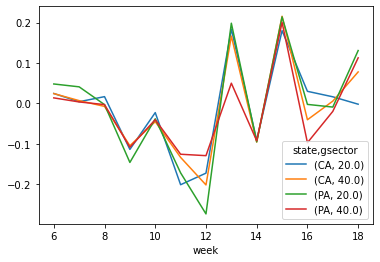

In [3]:
ax = weekly_port_ret.squeeze().unstack().T.plot()
# can access customization via matplotlib methods on ax 
plt.show()

Doing this in seaborn is easy too. 

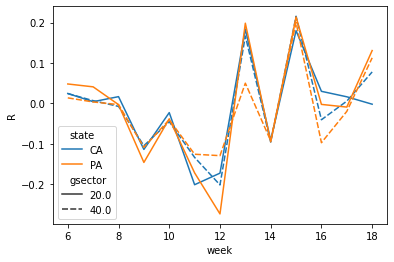

In [4]:
ax = sns.lineplot(data = weekly_port_ret,
             x='week',y='R',hue='state',style='gsector')
# can access customization via matplotlib methods on ax 
plt.show()


## Part 1 - Plot formatting

Insert cell(s) below this one as needed to finish this Part.

Improve the plot
- Q1: set the title to "Weekly Portfolio Returns - Daily Rebalancing"
- Q2: set the x-axis title to "Week in 2020"
- Q3: set the x-axis title to "Weekly Return"
- Q4: set the figure to 7" wide and 5" tall

- Ungraded bonus: change the lines so the states are different colors (but both CA lines the same color, both PA lines same color) 
- Ungraded bonus: change the financial portfolios to dashes (keep industrials solid)
- Ungraded bonus: change the legend so it says the industry names, not the numbers 

Tip: Look up the `pandas` [documentation on its plot function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html) if you use that, and 

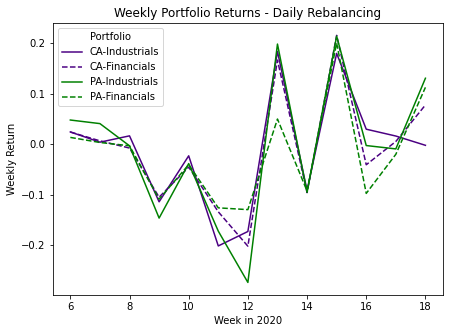

In [5]:
# pd version
ax = weekly_port_ret.squeeze().unstack().T.plot(
            title="Weekly Portfolio Returns - Daily Rebalancing",
            xlabel="Week in 2020",
            ylabel="Weekly Return",
            figsize = (7,5),
            # bonus:
            # lines: CA in indigo, PA in green
            # lines: 20 in dashes, 40 solid    
            style=['-','--','-','--'],
            color=['indigo','indigo','green','green'],

            # Bonuses:
            # week numbers --> dates
            )
# bonus:
ax.legend( ["CA-Industrials",
            "CA-Financials",
            "PA-Industrials",
            "PA-Financials",],
            title = "Portfolio", ) 
# ax.set_linestyle('dash')
plt.show()

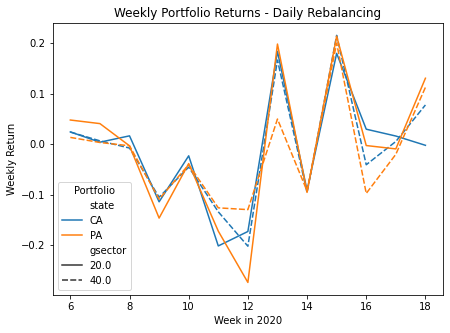

In [6]:
# sns version
fig, ax = plt.subplots(figsize = ( 7 , 5 )) 

sns.lineplot(data = weekly_port_ret,ax=ax, # "ax=ax" tells sns to put this plot in the ax object
             x='week',y='R',hue='state',style='gsector')\
   .set(title="Weekly Portfolio Returns - Daily Rebalancing",
        xlabel="Week in 2020",
        ylabel="Weekly Return",
    )
ax.legend( title = "Portfolio", ) 
plt.show()

## Part 2 - Replicate/Imitate

Insert cell(s) below this one as needed to finish this Part.

- Q5: Replicate this. Notice the x-axis has no label - it's in the title.

C:\Users\DonsLaptop\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


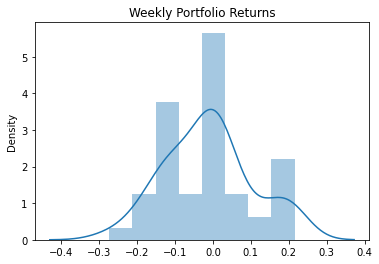

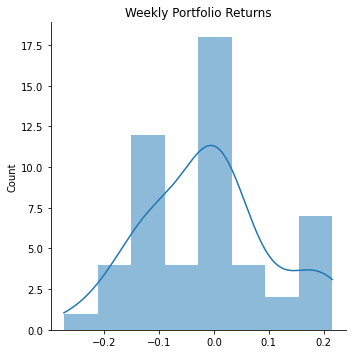

In [7]:
ax = sns.distplot(weekly_port_ret['R'])
ax.set(title='Weekly Portfolio Returns',xlabel='')
plt.savefig('../data/F1.png',facecolor='white', transparent=False )

# displot version:
    # displot, on my comp, likes adding edges to the bars, I don't like it
    # this next line changes the settings and turns it off (applies to all 
    # subseq plots)
plt.rcParams['patch.edgecolor'] = 'none' 
ax = sns.displot(weekly_port_ret['R'],legend=False,kde=True)
ax.set(title='Weekly Portfolio Returns',xlabel='')
ax.savefig('../data/F1-b.png',facecolor='white', transparent=False )


- Q6: Replicate this. Bins sizes of 5%.

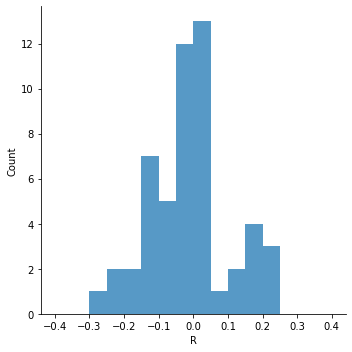

In [8]:
sns.displot(weekly_port_ret['R'],binwidth=.05, binrange=(-.4,.4))


C:\Users\DonsLaptop\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


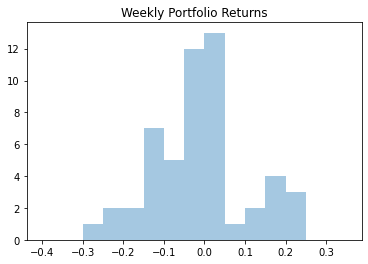

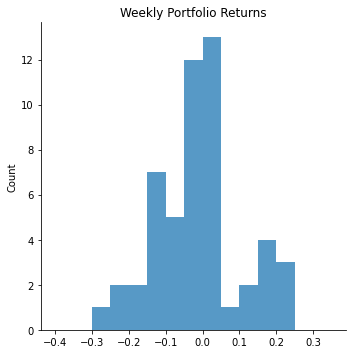

In [9]:
ax = sns.distplot(weekly_port_ret['R'],kde=False,bins=np.arange(-.4, .4, 0.05).tolist())
ax.set(title='Weekly Portfolio Returns',xlabel='')
plt.savefig('../data/F2.png',facecolor='white', transparent=False )

# displot version:
ax = sns.displot(weekly_port_ret['R'],legend=False,bins=np.arange(-.4, .4, 0.05).tolist())
ax.set(title='Weekly Portfolio Returns',xlabel='')
ax.savefig('../data/F2-b.png',facecolor='white', transparent=False )


- Q7: Replicate this. Pay attention to the header for a clue!

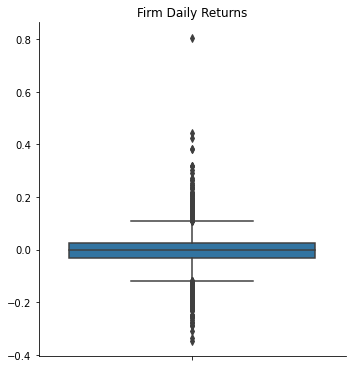

In [10]:
ax = sns.catplot(y="ret", kind="box", data=firm_rets)
ax.set(title='Firm Daily Returns',ylabel='')
ax.savefig('../data/F3.png',facecolor='white', transparent=False )



- Q8: Replicate this

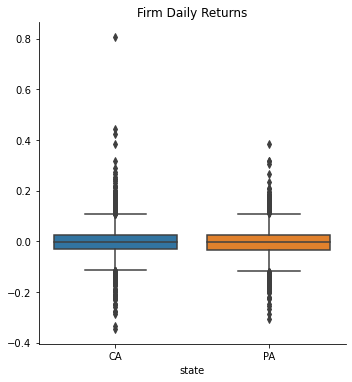

In [11]:
ax = sns.catplot(y="ret", x='state', kind="box", data=firm_rets)
ax.set(title='Firm Daily Returns',ylabel='')
ax.savefig('../data/F4.png',facecolor='white', transparent=False )

- Q9: Replicate this figure, using this dataset:

```python
total = pd.DataFrame() # open an empty dataframe
total['ret'] = (firm_rets.assign(ret=firm_rets['ret']+1) # now we have R(t) for each observation
                       .groupby('tic')['ret']    # for each firm,
                       .prod()                      # multiple all the gross returns
                       -1                           # and subtract one to get back to the total period return
)
total['cnt'] = firm_rets.groupby('tic')['ret'].count()
total['std'] = firm_rets.groupby('tic')['ret'].std()*np.sqrt(total['cnt'])
total = total.merge(firm_rets.groupby('tic')[['state','gsector']].first(), 
                    left_index=True, right_index=True)
```

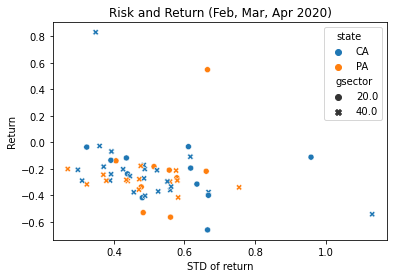

In [12]:
total = pd.DataFrame() # open an empty dataframe
total['ret'] = (firm_rets.assign(ret=firm_rets['ret']+1) # now we have R(t) for each observation
                       .groupby('tic')['ret']    # for each firm,
                       .prod()                      # multiple all the gross returns
                       -1                           # and subtract one to get back to the total period return
)
total['cnt'] = firm_rets.groupby('tic')['ret'].count()
total['std'] = firm_rets.groupby('tic')['ret'].std()*np.sqrt(total['cnt'])
total = total.merge(firm_rets.groupby('tic')[['state','gsector']].first(), 
                    left_index=True, right_index=True)

ax = sns.scatterplot(data=total,x='std',y='ret',hue='state',style='gsector')
ax.set(title='Risk and Return (Feb, Mar, Apr 2020)',ylabel='Return',xlabel='STD of return')
plt.savefig('../data/F5.png',facecolor='white', transparent=False )

- Q10: Choose your adventure. Use a pairplot, jointplot, or heatmap on any data already loaded on this page (including the original `firms_df`). Do something fun with the parameters of the function you choose. [Or adapt this](https://seaborn.pydata.org/examples/timeseries_facets.html) to improve  our portfolio returns plot from Part 1.